In [4]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [82]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
class DynamicObjectTrack:
    def __init__(self, x, P, create_frame_idx):
        self.kf = KalmanFilter(dim_x=6, dim_z=4)
        self.kf.x = x.T # x,y,vx,vy
        self.kf.F = np.eye(6)
        self.kf.P = np.diag([5,5,2,2,1,1])
        self.kf.P_post = self.kf.P.copy()
        self.kf.Q = np.diag([1,1,1,1,0,0])
        self.kf.H = np.zeros([4,6])
        self.kf.H[0,0] = 1
        self.kf.H[1,1] = 1
        self.kf.H[2,2] = 1
        self.kf.H[3,3] = 1
        self.saver = Saver(self.kf)
        self.create_frame_idx = create_frame_idx
        self.last_update_frame_idx = create_frame_idx
        self.hits = [1]
    
    def predict(self, dT):
        self.kf.F[0, 2] = dT
        self.kf.F[0, 4] = 0.5 * dT**2
        self.kf.F[1, 3] = dT
        self.kf.F[1, 5] = 0.5 * dT**2
        self.kf.F[2, 4] = dT
        self.kf.F[3, 5] = dT
        self.kf.predict()
        
    def update(self, z, cov, current_frame_idx):
        self.kf.update(z,R=cov)
        self.last_update_frame_idx = current_frame_idx
        
    def save(self):
        self.saver.save()
        
    def getHistory(self):
        self.saver.to_array()
        return self.saver.x
    
    def getStateVector(self):
        return self.kf.x
    
    def getPredictedStateVector(self):
        return self.kf.x_prior
        
    def getInnovationCovarianceMatrix(self):
        return self.kf.S
    
    def getCovarianceMatrix(self):
        return self.kf.P_post
    
    def getLastUpdateFrameIdx(self):
        return self.last_update_frame_idx
    

class DynamicTracker:
    def __init__(self):
        self.pnt_data_associator = PointObjectDataAssociator(dim=4,delta=3)
        self.dyn_object_list = []
        self.dyn_max_non_update_iterations = 5
        self.frame_idx = 0
        self.history_dyn_object_list = []
        self.last_ts = 0

    def run(self, z, dz, ts):
        self.frame_idx += 1
        print(f"Number of new plots {len(z)}")
        print(f"Number of dynamic tracks before run() {len(self.dyn_object_list)}")
        
        
        #Prediction
        if self.last_ts > 0:
            dT = (ts - self.last_ts) / 1e6
            self.last_ts = ts
            
            for dyn_track in self.dyn_object_list:
                dyn_track.predict(dT)
        self.last_ts = ts
        
        #Association
        Gp = self.p2t(z)
        
        #Update
        z, dz = self.trackUpdate(z, dz, Gp)
        
        #Init
        self.trackInit(z,dz)
            
        #Maintenance
        self.trackMaintenance()
        
        return self.getTracks()
        
    def p2t(self, measurements):
        Gp = np.zeros((len(measurements), len(self.dyn_object_list)))
        for idx_z, z in enumerate(measurements):
            z = z.reshape(-1,1)
            for idx_track, dyn_track in enumerate(self.dyn_object_list):
                x = dyn_track.getStateVector()
                x_pred = dyn_track.getPredictedStateVector()
                innov_cov = dyn_track.getCovarianceMatrix()
                #print(f"p2t: z={z}, x_pred={x_pred} innov_cov={innov_cov}")
                Gp[idx_z,idx_track] = self.pnt_data_associator.calcLikelihood(z, x_pred[0:4], innov_cov[0:4,0:4])
        
        #print(f"Gp = {Gp}")
        return Gp
    
    def trackUpdate(self, z, dz, Gp):
        assigned_meas_list = []
        while(1): #Iterate over GP
            i_meas, lp, i_trk = self.getBestAssociation(Gp)
            if(lp == 0):
                break
            self.zeroOutAssociation(Gp, i_meas, i_trk) # Clear from point association matrix
            zm = z[i_meas]
            cov = dz[i_meas]
            assigned_meas_list.append(i_meas)

            print(f"Updating track = {i_trk} z = {zm}")
            self.dyn_object_list[i_trk].update(z=zm.T,cov=cov, current_frame_idx=self.frame_idx)
                
        for i_meas in sorted(assigned_meas_list, reverse=True):
            z = np.delete(z, (i_meas), axis=0)
            dz = np.delete(dz, (i_meas), axis=0)
        
        return z, dz
        
    def trackInit(self, z, dz):
        for z,cov in zip(z,dz):
            x = np.zeros(6)
            x[0:4] = z
            new_trk = DynamicObjectTrack(x=x.reshape(1,-1), P=cov, create_frame_idx=self.frame_idx)
            print(f"Initiating new track: x={x}")
            self.dyn_object_list.append(new_trk)

            
    def deleteTrack(self, track_list, indices):
        delete_indices  = np.unique(indices)
        #print("deleteTrack is called. track list length:", len(track_list), "indices", indices)
        for index in sorted(delete_indices, reverse=True):
            self.history_dyn_object_list.append(track_list[index])
            del track_list[index]
        
    def trackMaintenance(self):
        dyn_delete_list = []
        for i_trk,trk in enumerate(self.dyn_object_list):
            trk.save()
            if self.frame_idx - trk.getLastUpdateFrameIdx() > self.dyn_max_non_update_iterations:
                dyn_delete_list.append(i_trk)

        self.deleteTrack(self.dyn_object_list, dyn_delete_list)
        
    def isTrkSimilar(self, x_cand):
        x, y, vx, vy = x_cand[0], x_cand[1], x_cand[2], x_cand[3]
        for trk in self.dyn_object_list:
            state_adv = trk.getStateVector()
            x_adv, y_adv, vx_adv, vy_adv = state_adv[0], state_adv[1], state_adv[2], state_adv[3] 
            
            pos_thr = 4
            vel_thr = 1
            pos_dist = sqrt((x-x_adv)**2+(y-y_adv)**2)
            vel_dist = sqrt((vx-vx_adv)**2+(vy-vy_adv)**2)
            if dist > dist_thr or vel_dist > vel_thr:
                return True
        
        return False
                
                    
    @staticmethod
    def getBestAssociation(Gp):
        i_meas,lp,i_trk_p = None,0,None
        if Gp.size > 0:
            ind = np.unravel_index(np.argmax(Gp, axis=None), Gp.shape)
            i_meas = ind[0]
            i_trk_p = ind[1]
            lp = Gp[ind]
        
        return i_meas,lp, i_trk_p
    
    @staticmethod
    def zeroOutAssociation(mat, i, j, k=None):
        if mat is not None:
            if mat.ndim == 2:
                mat[i, :] = 0
                mat[:, j] = 0
            elif mat.ndim == 3:
                mat[i, :, k] = 0
                mat[:, j, k] = 0
        
        return mat
          
    @staticmethod
    def createProbabilityMatrix(pairs):
        if pairs:
            u_meas = np.unique([item[0] for item in pairs])
            u_trk = np.unique([item[1] for item in pairs])
            P = np.zeros((len(u_meas),len(u_trk)))
            for i in range(0, len(u_meas)):
                for j in range(0, len(u_trk)):
                    P[i,j] = max([pair[2] if pair[0]==u_meas[i] and pair[1]==u_trk[j] else 0 for pair in pairs])
        else:
            P = None
            
        #print("createProbabilityMatrix: P = ", P)
 
        return P
    
    def getTracks(self):
        return self.dyn_object_list
    
    def getHistory(self):
        return self.history_dyn_object_list + self.dyn_object_list 

In [31]:
scene_id = 426
N = 800

dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=N)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 ...
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]]


/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

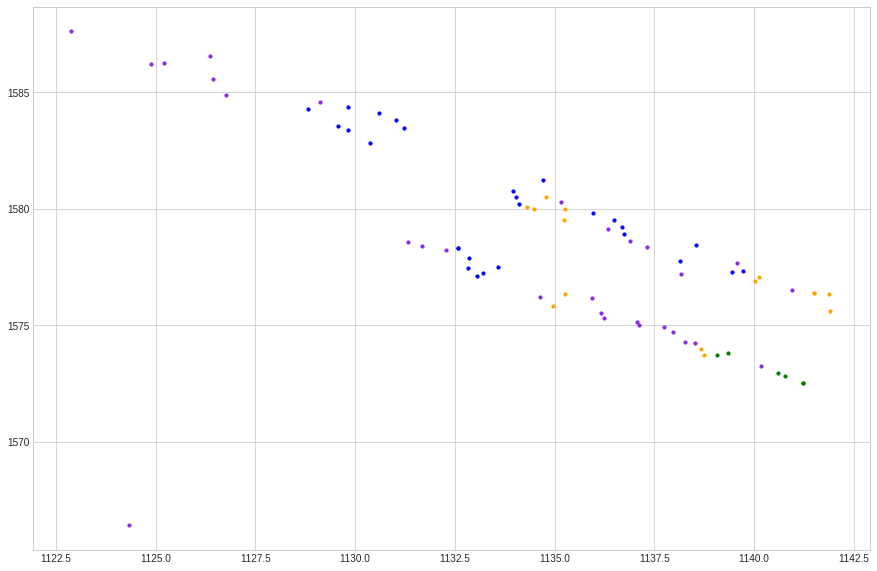

In [91]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,20):
    pc = dataset.getDynamicPoints(t)
    pc = np.squeeze(pc[np.where(pc[:,3]==0) or np.where(pc[:,3]==2) or np.where(pc[:,3]==6), :], axis=0)
    clus = DBSCAN(eps=2, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    for i in range(pc.shape[0]):
        v_comp = np.sqrt(pc[i,8]**2 + pc[i,9]**2)
        if v_comp > 3:
            #c = int(np.round(v_comp) % 17)
            ax.scatter(pc[i,0], pc[i,1], s=10, c=colors[c[i]])

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

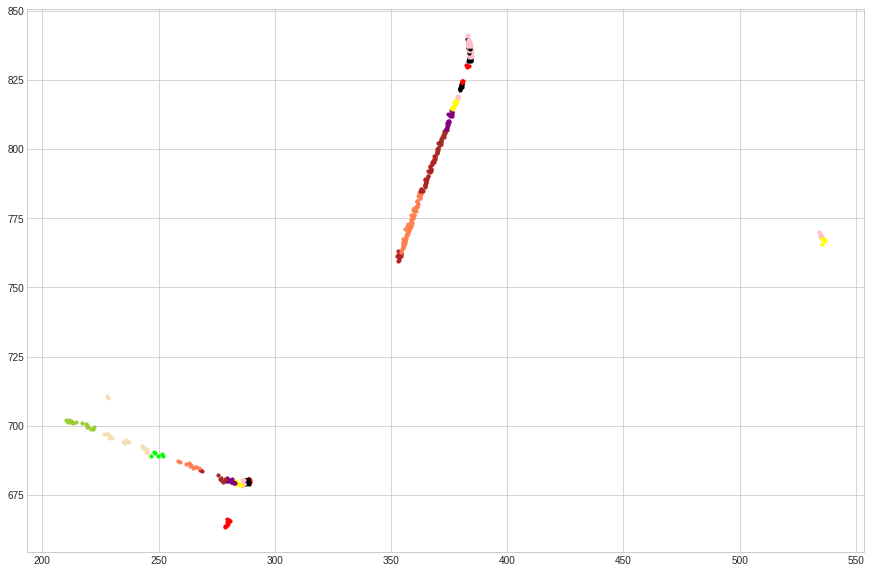

In [99]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,800):
    pc = dataset.getDynamicPoints(t)
    pc = np.squeeze(pc[np.where(pc[:,3]==0) or np.where(pc[:,3]==2) or np.where(pc[:,3]==6), :], axis=0)
    if pc.shape[0] < 1:
        continue
    clus = DBSCAN(eps=2, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in range(len(n_clusters)):
        if c[i] == -1:
            continue
        x_com = pc[c==i,0]
        y_com = pc[c==i,1]
        vx_com = np.mean(pc[c==i,8])
        vy_com = np.mean(pc[c==i,9])
        v_comp = np.sqrt(vx_com**2 + vy_com**2)
        if v_comp > 3:
            color = int(np.round(v_comp) % 17)
            ax.scatter(x_com, y_com, s=10, c=colors[color])

In [170]:
from sklearn.cluster import DBSCAN
import numpy as np

def runClustering(pc):
    X_list = []
    P_list = []
    
    if pc.shape[0] < 1:
        return X_list, P_list
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in n_clusters:
        if i == -1:
            continue

        ci = pc[c==i, :]
        x_com = np.mean(ci[:,0])
        y_com = np.mean(ci[:,1])
        vx_com = -1*np.mean(ci[:,8])
        vy_com = 1*np.mean(ci[:,9])
        v_comp = np.sqrt(vx_com**2 + vy_com**2)
        if v_comp < 2:
            continue
        x_var = np.var(ci[:,0]) + 1
        y_var = np.var(ci[:,1]) + 1
        vx_var = np.var(ci[:,8]) + 1
        vy_var = np.var(ci[:,9]) + 1
        X = np.array([x_com, y_com, vx_com, vy_com])
        P = np.diag([x_var, y_var, vx_var, vy_var])
        X_list.append(X)
        P_list.append(P)
        
    return X_list, P_list

In [184]:
tracker = DynamicTracker()
for t in range(0,100):
    pc, ts = dataset.getDynamicPoints(t)
    X, P = runClustering(pc)
    #print(f"X={X} P={P}")
    tracker.run(X, P, ts)
    


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 0
Initiating new track: x=[251.82635509 689.33273911 -11.25447893   1.66170973   0.
   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [249.42298957 689.91663665 -11.24165201   1.70571595]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [248.34486381 689.69107926 -11.26830959   1.81629834]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [247.8198272  690.30317883 -11.47629833   1.77177835]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [247.01376019 690.27289639 -11.45893192   1.82456553]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [246.2629432  690.77767244 -11.71566248   1.81969053]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [244.6313431  691.18285248 -11.70845286   1.84478068]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [243.80627566 691.61958333 -11.71601899   1.82021046]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [241.85317034 691.62711513 -11.68243885   1.92487514]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [237.53299212 692.64379058 -11.90518236   2.02478588]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [237.00601988 693.14492232 -11.92125511   1.97755545]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [236.0073979  693.9655674  -12.10990143   1.92779446]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [235.50446216 694.15495891 -12.10977777   1.92446788]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [234.66548028 694.70718501 -12.20505524   1.89805996]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [229.59317191 696.01422886 -12.18555784   1.95728624]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [229.24811172 696.64708848 -12.20907164   1.88464642]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [227.68384853 696.67903501 -12.18664384   1.95414016]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[ 2.28132968e+02  7.10428597e+02 -1.22491469e+01  9.78653543e-02
  0.00000000e+00  0.00000000e+00]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.27014935e+02  7.10449689e+02 -1.24977221e+01  1.69062451e-01]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 2
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.26078254e+02  7.10601094e+02 -1.23714685e+01  2.06830628e-01]
Initiating new track: x=[223.5347004  699.52689972 -12.3671279    1.78277987   0.
   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [221.5930399  698.62444258 -12.42671633   2.00539607]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [221.20164933 699.16938639 -12.44338083   1.95183074]
Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [219.73872805 699.82337135 -12.44972897   1.9324854 ]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [219.24698046 699.88928428 -12.44509443   1.94505858]
Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [218.31581693 699.54945345 -12.41823928   2.02450816]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 3
Updating track = 0 z = [218.05521942 700.70110361 -12.4625206    1.89418405]
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [213.81038109 701.00103973 -12.41791773   2.03084087]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [212.89391764 701.40583942 -12.42206955   2.01861703]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [211.87941264 701.33777106 -12.40528297   2.06615758]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [211.71921366 701.53431089 -12.41108751   2.04912901]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [210.7915722  702.1328573  -12.42286301   2.01594478]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [208.34194617 702.62857494 -12.41079235   2.05170751]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [205.57831179 703.16918008 -12.39742756   2.09156048]
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [203.84446749 703.73659803 -12.64074564   2.13290691]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [202.34399045 704.74974917 -12.5376749    2.0567435 ]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [200.37290316 704.65006004 -12.3882246    2.11446714]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [199.25068341 704.4477305  -12.61216545   2.2141645 ]
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[279.53830354 664.77625343  -2.57059964   2.12440916   0.
   0.        ]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [279.85081413 665.51567394  -2.46430969   1.93946034]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [279.63722978 664.89561604  -2.42202413   1.98619974]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [279.15816397 664.4130925   -2.33053541   1.96836644]
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[187.88762978 708.82394276 -12.51498032   2.12346244   0.
   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [186.76058524 708.39739416 -12.60993433   2.217448  ]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [185.4019383  707.53022578 -12.56579781   2.3369348 ]
Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[185.4096088  710.12540755 -12.65210438   2.09804595   0.
   0.        ]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 2
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 2
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 2
Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[ 2.89018629e+02  6.79101538e+02 -4.12445199e+00  4.36117789e-02
  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 0
Number of dynamic tracks before run() 1
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [ 2.86140423e+02  6.78350843e+02 -5.44270563e+00  5.59506387e-01]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Initiating new track: x=[ 2.88919408e+02  6.80130481e+02 -3.49461869e+00 -1.09918057e-01
  0.00000000e+00  0.00000000e+00]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.88567918e+02  6.80070338e+02 -3.74729341e+00 -7.86719071e-02]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.88230401e+02  6.79965180e+02 -3.87312277e+00 -3.09740032e-02]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.87874076e+02  6.80039128e+02 -3.93649209e+00 -1.52821704e-02]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.87441597e+02  6.79645789e+02 -4.36924565e+00  1.06082404e-01]
Number of new plots 1
Number of dynamic tracks before run() 2
Updating track = 1 z = [ 2.86547815e+02  6.79470385e+02 -4.88515940e+00  2.40913926e-01]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [ 2.86285114e+02  6.78841486e+02 -5.46604419e+00  4.32208061e-01]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [ 2.85730196e+02  6.79432885e+02 -5.30705182e+00  3.52670362e-01]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [ 2.85433065e+02  6.78724163e+02 -5.69423556e+00  5.64093769e-01]
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [ 2.84496281e+02  6.78875017e+02 -6.05434513e+00  6.55302018e-01]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [283.69465616 679.06828996  -6.29361224   0.71106434]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [282.93298198 679.46665944  -6.32286119   0.69056288]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [282.71673426 679.35632876  -6.53671765   0.76137415]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [282.01117698 679.80515532  -6.58300749   0.72837909]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [281.2112568  680.00272345  -6.57534218   0.75620699]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [281.12234967 680.0625371   -6.66069603   0.75444146]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [279.9220601  680.27565583  -6.89323044   0.84240028]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [279.83793401 680.33518506  -7.03958797   0.8579444 ]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [279.30023988 680.40520312  -7.18685508   0.91098699]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [278.98257676 680.58667933  -7.36521637   0.92279474]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [277.7966131  680.22153298  -7.48749844   1.13870927]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [277.84887299 680.83838736  -7.64162413   1.01876692]
Number of new plots 1
Number of dynamic tracks before run() 1
Updating track = 0 z = [276.30496349 681.2964037   -7.83218352   1.09537836]


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Total number of tracks = 8
(7, 6, 1)
(9, 6, 1)
(57, 6, 1)
(10, 6, 1)
(9, 6, 1)
(7, 6, 1)
(13, 6, 1)
(24, 6, 1)


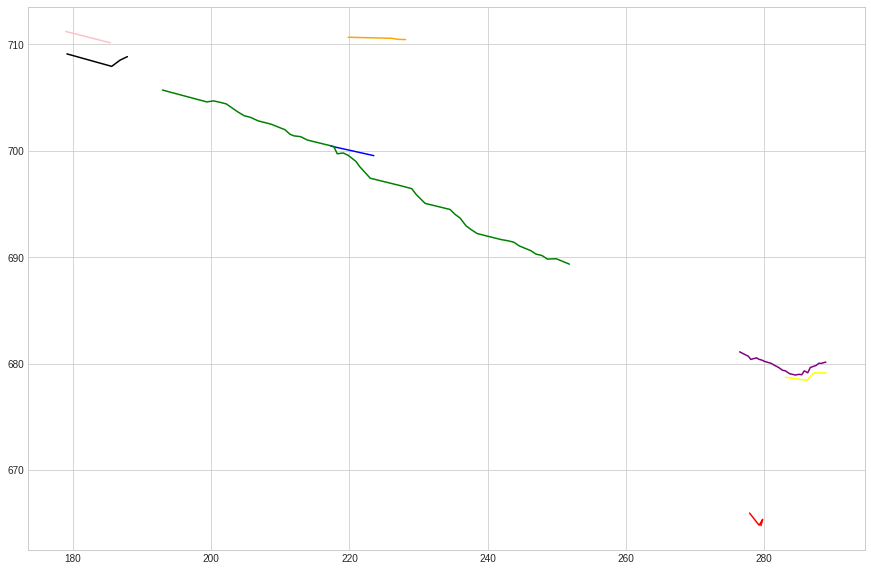

In [185]:
tracks = tracker.getHistory()
N = len(tracks)
print(f"Total number of tracks = {N}")

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for idx,track in enumerate(tracks):
    history = track.getHistory()
    print(history.shape)
    ax.plot(history[:,0], history[:,1], color=colors[idx])